In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
file = r"C:\Users\zacwa\bike_sharing_daily.csv"
bikes = pd.read_csv(file,sep=',')
bikes['dteday'] = pd.to_datetime(bikes.dteday,format='%Y-%m-%d')
bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


data \
https://www.kaggle.com/datasets/contactprad/bike-share-daily-data?resource=download

The below visualizations indicate that there could be outliers. I'll explore that possibility with a handful of methods.

The data's coding of seasons doesn't appear to make sense. Fall temps shouldn't be that much higher than summer. But I'll ignore that for the sake of this exercise and assume the data was generated and coded accurately.

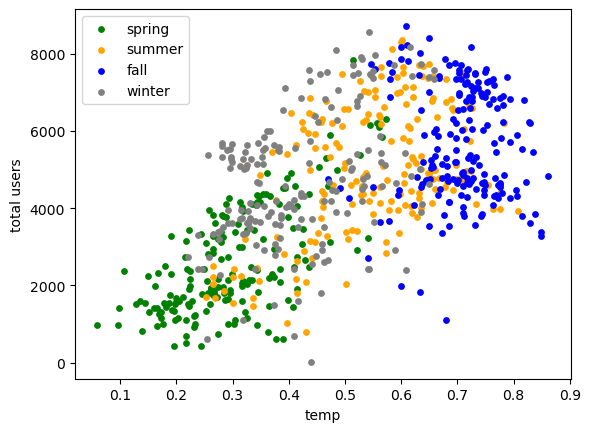

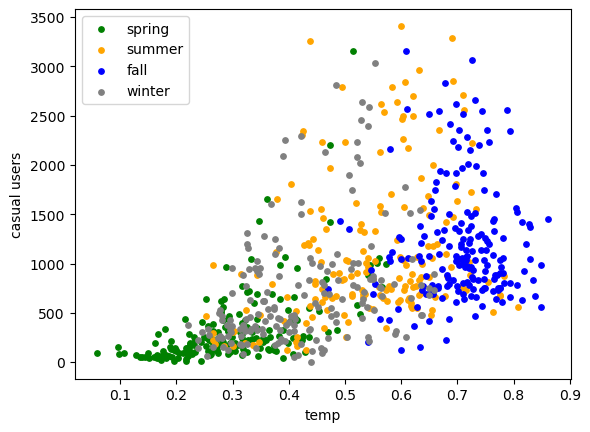

In [3]:
season_code = bikes.season.unique().tolist()
season_code.sort()
seasons = ['spring','summer','fall','winter']
cs = ['green','orange','blue','gray']
def usertemp(bikes):
    for sc, s, c in zip(season_code,seasons,cs):
        temp = bikes.loc[bikes.season==sc,'temp'].copy()
        tusers = bikes.loc[bikes.season==sc,'cnt'].copy()
        plt.scatter(temp,tusers,c=c,label=s,s=15)
    plt.xlabel('temp')
    plt.ylabel('total users')
    plt.legend()
    plt.show()

    for sc, s, c in zip(season_code,seasons,cs):
        temp = bikes.loc[bikes.season==sc,'temp'].copy()
        tusers = bikes.loc[bikes.season==sc,'casual'].copy()
        plt.scatter(temp,tusers,c=c,label=s,s=15)
    plt.xlabel('temp')
    plt.ylabel('casual users')
    plt.legend()
    plt.show()

usertemp(bikes)

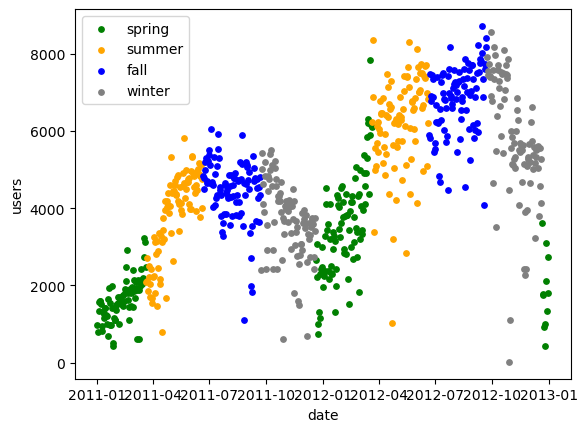

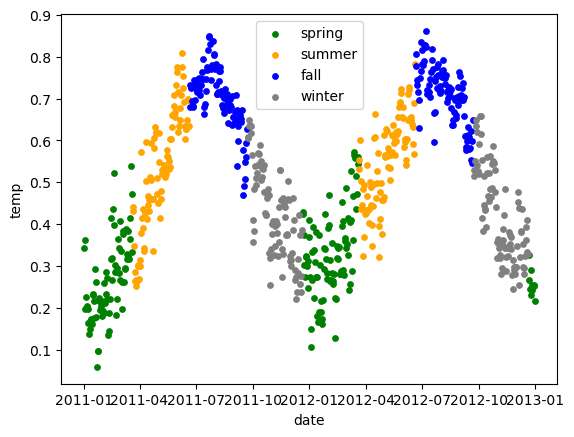

In [4]:
def usertempseries(bikes):
    for sc, s, c in zip(season_code,seasons,cs):
        day = bikes.loc[bikes.season==sc, 'dteday'].copy()
        cnt = bikes.loc[bikes.season==sc, 'cnt'].copy()
        plt.scatter(day,cnt,c=c,label=s,s=15)
    plt.legend()
    plt.xlabel('date')
    plt.ylabel('users')
    plt.show()

    for sc, s, c in zip(season_code,seasons,cs):
        day = bikes.loc[bikes.season==sc, 'dteday'].copy()
        temp = bikes.loc[bikes.season==sc, 'temp'].copy()
        plt.scatter(day,temp,c=c,label=s,s=15)
    plt.legend()
    plt.xlabel('date')
    plt.ylabel('temp')
    plt.show()

usertempseries(bikes)

### Outlier Detection

#### Using Nearest Neighbors
I'll designate outliers as points that are either associated with the fewest neighborhood sets or the largest in-neighborhood distance to a neighbor. 

In [5]:
quant_vars = ['temp', 'atemp', 'hum', 'windspeed','cnt']
bq = bikes[quant_vars]
all_vars = ['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed','cnt'] # minus casual and registered
select_vars = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'atemp', 'hum', 'windspeed']
ba = bikes[all_vars] # minus date 

In [6]:
def z_scores(X):
    n = X.shape[0]
    X = X.to_numpy().reshape(n,-1)
    scaler = StandardScaler(with_mean=True,with_std=True)
    return scaler.fit_transform(X)

In [7]:
bqz = z_scores(ba)
bco = PCA(n_components=3).fit_transform(bqz)

#### Collect neighborhood sets and max neighbor distances

In [8]:
bcodf = pd.DataFrame(bco).rename(columns={0:'pc1',1:'pc2',2:'pc3'})

m, n = bcodf.shape
B = np.asarray(bcodf)
k = 5
max_ndist_vector = np.zeros(m)

def distfunc(x,y):
    return np.linalg.norm(x-y,axis=1)

hc = defaultdict(list)
for i in range(m):
    bi = B[i,:]
    j_idx = np.arange(m)[np.isin(np.arange(m),[i],invert=True)]
    b_i = B[j_idx,:]

    distances = distfunc(bi,b_i)
    dist_idx = np.argsort(distances)[:k]

    # hood sets
    hood_idx = j_idx[dist_idx]
    hd_copy = hood_idx
    for o in hood_idx:
        hd_copy.sort()
        hc[o].append(tuple(hd_copy))

    # hood dists
    max_ndist_vector[i] = np.max(distances[dist_idx])


In [9]:
# count of neighborhood sets for each observation
hood_counts = np.zeros(m) 
for k,v in hc.items():
    hood_counts[k] = len(set(v))

In [10]:
pct_outs = 0.05
number_of_outliers_expected = int(m*pct_outs)
print(number_of_outliers_expected)

idx_outliers = np.argsort(max_ndist_vector)[::-1][:number_of_outliers_expected]
bcodf['hoods'] = hood_counts

bcodf['max_dist'] = max_ndist_vector
bcodf['outlier_max_dist'] = False
bcodf.loc[idx_outliers,'outlier_max_dist'] = True

idx_count_outs = np.argsort(hood_counts)[:number_of_outliers_expected]
bcodf['outlier_hoods'] = False
bcodf.loc[idx_count_outs,'outlier_hoods'] = True

36


The counting neighborhoods approach doesn't look like it will be effective here. Subsetting the data by pc2 and pc3 gives an outlier grouping. The neighborhood set counting does not identify these as outliers because they still have high neighborhood counts. The cause of this is that outliers are clustered rather than isolated. It may then be debated if these are "outliers" at all as there may be a reason worth knowing why the supposed "outliers" occur in proximity to each other in a particular area. 

In [11]:
bcodf.loc[(bcodf.pc2<2)&(bcodf.pc3>3),:]

,pc1,pc2,pc3,hoods,max_dist,outlier_max_dist,outlier_hoods
16,4.127057,0.462107,3.806636,1.0,2.560328,True,False
51,3.624213,0.440574,3.475586,3.0,2.279171,True,False
104,1.336679,-0.198649,3.572961,0.0,1.719606,True,True
149,-0.642688,-0.219929,3.548169,0.0,1.495080,True,True
184,-1.561434,0.809110,3.620080,1.0,1.505180,True,True
247,-0.622422,1.789859,3.687161,2.0,1.620499,True,False
282,-1.551621,1.124398,4.875072,4.0,1.648448,True,False
314,1.013602,-0.045962,5.281486,2.0,1.995077,True,False
327,0.666686,0.912006,5.266860,5.0,1.765980,True,False
359,2.206379,0.080190,5.029984,9.0,1.986968,True,False


None of the outliers identified by max distance are identified by neighborhood set counts.

In [12]:
bcodf.nlargest(10,'max_dist',keep='all')

,pc1,pc2,pc3,hoods,max_dist,outlier_max_dist,outlier_hoods
366,3.492598,-2.243001,4.156066,2.0,2.800401,True,False
16,4.127057,0.462107,3.806636,1.0,2.560328,True,False
415,2.675320,-1.623299,4.120994,4.0,2.303694,True,False
51,3.624213,0.440574,3.475586,3.0,2.279171,True,False
550,-2.451882,-1.564165,3.788818,3.0,2.163470,True,False
471,-0.503875,-1.985295,3.600254,1.0,2.144727,True,False
380,3.435734,-1.439592,4.211539,4.0,2.119174,True,False
724,1.934682,1.592916,4.307888,4.0,2.026680,True,False
314,1.013602,-0.045962,5.281486,2.0,1.995077,True,False
359,2.206379,0.080190,5.029984,9.0,1.986968,True,False


#### Here's a look at the outliers identified by the largest in-neighborhood distance from their furthest neighbor, where k=5

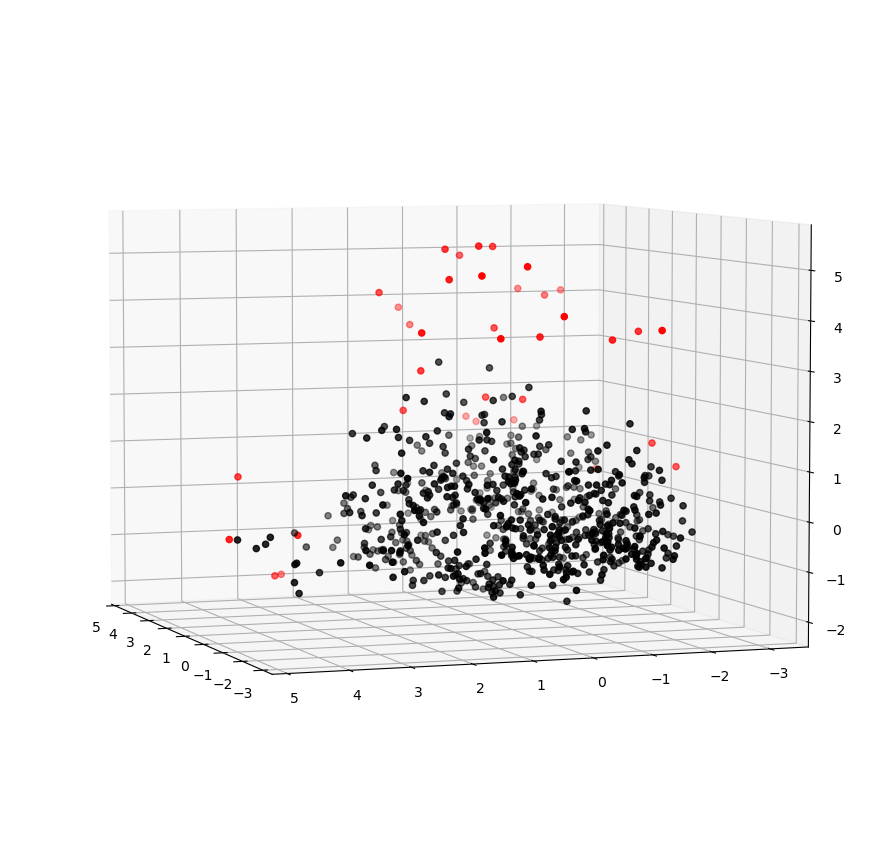

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(121,projection='3d')
fig.set_figheight(11)
fig.set_figwidth(11)
ax = plt.axes(projection='3d')

for o in [True,False]:
    co = 'Red' if o else 'Black'
    c_temp = bcodf.loc[bcodf.outlier_max_dist==o].copy()
    ax.scatter(c_temp.pc1,c_temp.pc2,c_temp.pc3,c=co)
ax.azim = 160
ax.elev = 5
ax.roll = 0

#### Here's a look at outliers identified by having the lowest neighborhood memberships
I believe this doesn't work due to the characteristics of the data. The outlying observations are near to other outlying observations.

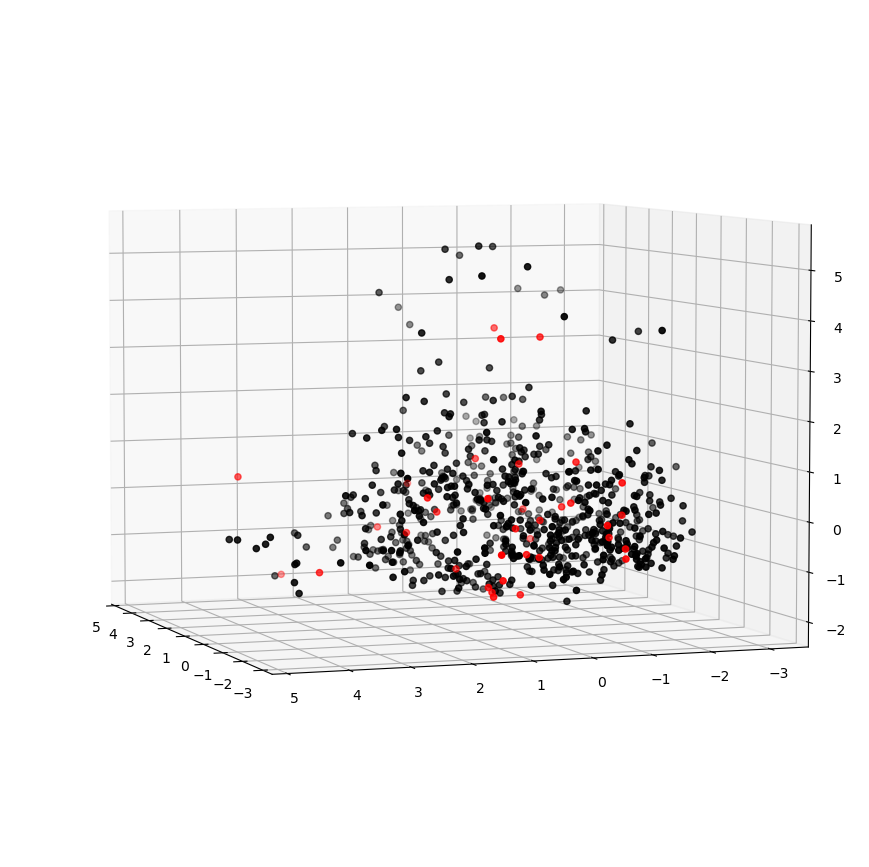

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(121,projection='3d')
fig.set_figheight(11)
fig.set_figwidth(11)
ax = plt.axes(projection='3d')

for o in [True,False]:
    co = 'Red' if o else 'Black'
    c_temp = bcodf.loc[bcodf.outlier_hoods==o].copy()
    ax.scatter(c_temp.pc1,c_temp.pc2,c_temp.pc3,c=co)
ax.azim = 160
ax.elev = 5
ax.roll = 0